In [27]:
from htc_class_testing import HolsteinTavisCummings
import numpy as np
from qutip import *
from qutip.core.gates import *
from numpy import array
from numpy import real
import matplotlib.pyplot as plt
pi = np.pi
LiH_params = {
    'w_q1': 0.12086,         # Qubit 1 frequency in a.u.
    'w_q2': 0.12086,         # Qubit 2 frequency
    'w_vib1': 0.00622913,       # Vibrational mode 1 frequency
    'w_vib2': 0.00622913,      # Vibrational mode 2 frequency
    'w_cav': 0.12086,        # Cavity frequency
    'S_1': 0, # 10.5615447 ,         # Huang-Rhys factor for qubit 1 and vib 1
    'S_2': 0, # 10.5615447 ,         # Huang-Rhys factor for qubit 2 and vib 2
    'lambda_1': 0.01,     # Cavity coupling strength for qubit 1
    'lambda_2': 0.01,    # Cavity coupling strength for qubit 2
    'N_vib': 2,         # Number of vibrational states to include
    'N_cav': 2,          # Cavity truncation level
    'qubit_1_dipole_moments' : 
    { 
        'mu_g': -2.354965266795868, #ground dipole moment
        'mu_e': 2.0510843691207983, #excited dipole moment
        'mu_eg': 1.0338263686725813 #transition dipole moment
    },
    'qubit_2_dipole_moments' : 
    { 
        'mu_g': -2.354965266795868, #ground dipole moment
        'mu_e': 2.0510843691207983, #excited dipole moment
        'mu_eg': 1.0338263686725813 #transition dipole moment
    }
}


# local qubit operators
sz = sigmaz()
sm = destroy(2)
sp = sm.dag()
# qubit number operator
nq = sp * sm

# local cavity operators
am = destroy(2)
ap = am.dag()
# cavity number operator
nc = ap * am

# identities
Iq = qeye(2)
Ic = qeye(2)

# frequencies
omega_q = LiH_params["w_q1"]
omega_c = LiH_params["w_cav"]

# qubit transition dipole moment
mu_eg = LiH_params["qubit_1_dipole_moments"]["mu_eg"]

# field-squared dipole moment
d_eg = LiH_params["lambda_1"] * mu_eg

# qubit-cavity coupling 
g = -np.sqrt(omega_c / 2 ) * d_eg

# local qubit 1 Hamiltonian
H_q1_local = -omega_q / 2 * sz

# local qubit 2 Hamiltonian
H_q2_local = -omega_q / 2 * sz

# local cavity Hamiltonian
H_cav_local = omega_q * ap @ am

# bare Hamiltonians in composite space
H_q1 = tensor(H_q1_local, Iq, Ic)
H_q2 = tensor(Iq, H_q2_local, Ic)
H_cav = tensor(Iq, Iq, H_cav_local)

# define H_bare_total as the sum of the three bare Hamiltonians for qubit 1, qubit 2, and cavity
# all on the composite space
H_bare_total = H_q1 + H_q2 + H_cav

# qubit1 - cavity interaction in order q1 x q2 x cav
H_q1_cav = g * tensor(sp, Iq, am) + g * tensor(sm, Iq, ap)
H_q2_cav = g * tensor(Iq, sp, am) + g * tensor(Iq, sm, ap)

tlist = np.linspace(0, 1400, 5000)



In [28]:
# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * np.abs(g))

# resonant iSWAP gate
T0_2 = T0_1 + T_gate_1
T_gate_2 = (2 *pi)/(4 * np.abs(g))

print(T_gate_1)
print(T_gate_2)

309.04091372701396
618.0818274540279


In [29]:
def wc_t(t, args=None):
    return 1

def w1_t(t, args=None):
    if t > T0_1 and t <= T0_1 + T_gate_1:
        return 1
    else:
        return 0

def w2_t(t, args=None):
    if t > T0_2 and t <= T0_2 + T_gate_2:
        return 1
    else:
        return 0



In [32]:
# time-dependent H; H_q1 + H_q2 + H_cav on at all times, H_q1_cav on until T1, H_q2_cav on from T1 to T1+T2
H_t = [[H_bare_total, wc_t], [H_q1_cav, w1_t], [H_q2_cav, w2_t]]

# operators in composite space for expectation values
nq1 = tensor(nq, Iq, Ic)
nq2 = tensor(Iq, nq, Ic)
ncav = tensor(Iq, Iq, nc)

In [33]:
psi0 = tensor(basis(2,1), basis(2,0),basis(2,0))

In [34]:
psi0

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

In [35]:
res = mesolve(H_t, psi0, tlist, [], e_ops=[])

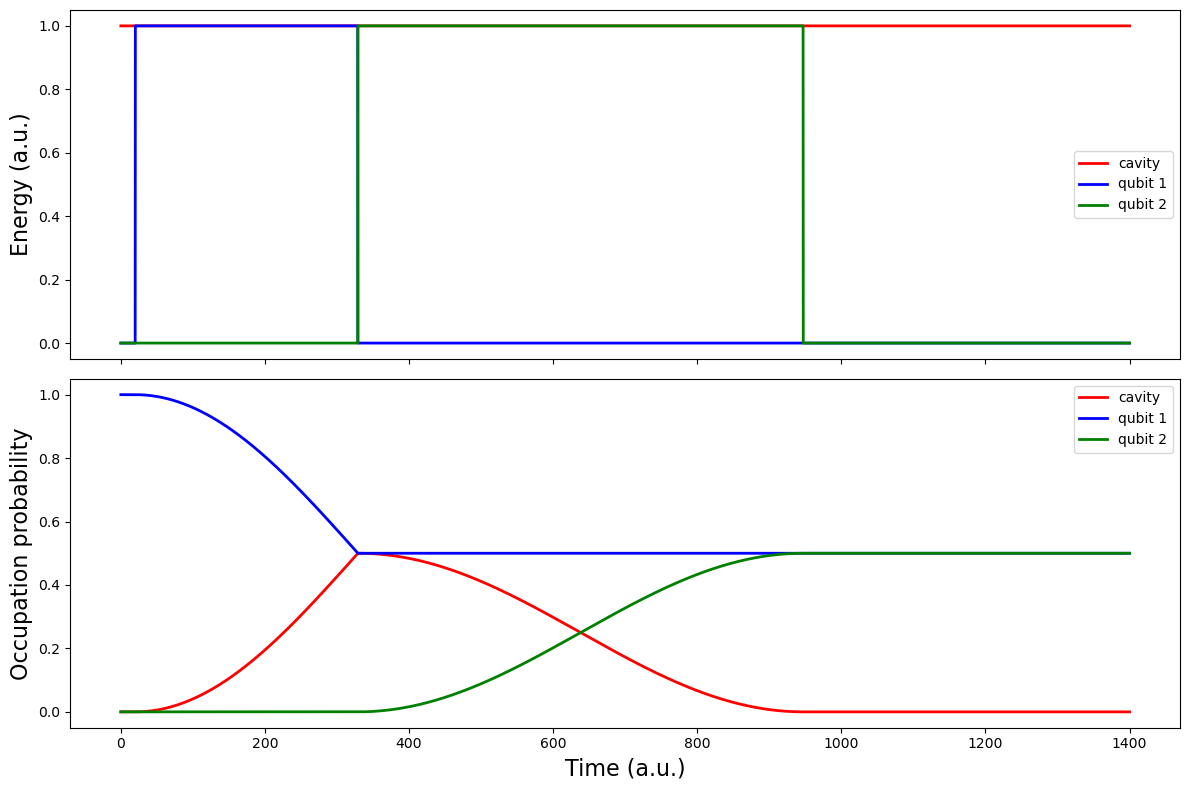

In [37]:
from numpy import real
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))), 'g', linewidth=2, label="qubit 2")
#axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (a.u.)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(ncav, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(nq1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(nq2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_xlabel("Time (a.u.)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

In [38]:
rho_final = res.states[-1]
rho_final

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        +0.00000000e+00j]
 [ 0.        -1.97944727e-06j]
 [-0.70711021+0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.70710336+0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]]

In [39]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [0,1])
rho_qubits

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.91821150e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.00004843e-01 -5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-01  4.99995157e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

In [ ]:
rho_qubits_ideal1 = ket2dm(tensor(phasegate(0), phasegate(pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal2 = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal1)

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal2)

In [ ]:
concurrence(rho_qubits)

In [ ]:
# rho_q_cav = ptrace(rho_final, [0,4])
# fid1 = fidelity(rho_q_cav, rho

In [ ]:
# test = system.H_cav.eigenenergies().tolist()
# test.sort()
# test